## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from Modules.muon import Muon
from Modules.positron import Positron
import Modules.functions as func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Setting graph defaults to avoid repetition on each plot
mpl.rcParams["axes.formatter.limits"] = -2, 2  # Sets xticks to use exponents
mpl.rcParams["axes.grid"] = True  # Turns grid on
mpl.rcParams["legend.loc"] = "best"  # Turns legend on and autoplaces it

In [2]:
# TODO: Move into functions.py
def format_subplot(ax, xlab, ylab, title, grid=True, legend=True):
    ax.set_xlabel(f"{xlab}")
    ax.set_ylabel(f"{ylab}")
    ax.set_title(f"{title}")
    if not legend:
        ax.legend().remove()
    if not grid:
        ax.grid(None)

## Setting up muons with all attributes

Generate "N" muons and create/store attributes dependent on lifetime, field strength, and field direction

In [3]:
# Setting up particles and fields
N = 10000
field_strength = 3e-3
field_dir = np.array([1, 0, 0])
a0 = 1/3
particles = [Muon() for _ in range(N)]

# Applying field and determining asymmetry
for p in particles:
    """
    Gets larmor_freq, angle between spin and field,
    total_rads revolved and polarisation of Muon()
    """
    p.apply_field(field_dir, field_strength)
    p.asym = func.count_asym(a0, func.larmor_freq(field_strength), p.lifetime)

# Sorting particles list by lifetime
particles.sort(key=lambda x: x.lifetime)

# Storing values in arrays
times = list(map(lambda p: p.lifetime, particles))
asym = list(map(lambda p: p.asym, particles))
polar = list(map(lambda p: p.polarisation, particles))
# Take the modulus w.r.t 2pi so that value is {0, 2pi}. makes 2*n*pi == 2*pi
rads = list(map(lambda p: p.total_rads%(2*np.pi), particles))
polar_asym = [x*y for x, y in zip(polar, asym)]

#### Asymmetry
$A = a_0 \cos{(\omega \tau)}$

#### Polarisation
$\cos(\theta)^2 +  \sin(\theta)^2 \cos(\omega \tau)$

#### Decay orientation
Larmor frequency times lifetime of muon

#### Lifetime
Take the inverse of the decay function
$\lambda~e^{-\lambda \tau} \rightarrow \dfrac{-ln(U)}{\lambda}$<br>
Where U is a random number in range {0, 1}<br>
This returns a lifetime proportional to the exponential decay of muons.<br>
A histogram plot of the lifetimes confirms this works.


## Plotting asymmetry, polarisation and product

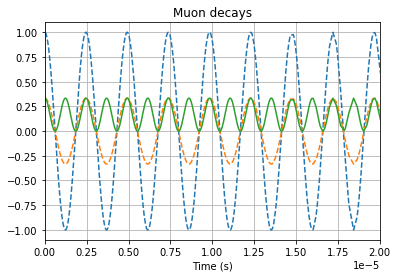

In [4]:
plt.figure()
plt.plot(times, polar, "--", label="Polarisation")
plt.plot(times, asym, "--", label="Asymmetry")
plt.plot(times, polar_asym, label="Polar * asym")

# FORMATTING
plt.xlabel("Time (s)")
plt.title("Muon decays")
plt.xlim(0, 20e-6)
plt.show()


## Asymmetry plot

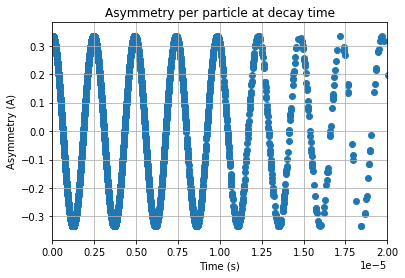

In [5]:
# PLOTTING
plt.figure()
plt.scatter(times, asym, label="Particle asymmetry")

# PLOT LABELS
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Asymmetry per particle at decay time")
plt.xlim(0, 20e-6)
plt.show()

## Plot of angle against decay time
Decay angle is a value [0, 2pi] for muons depending on larmor frequency and lifetime.

Attempting to recreate this image
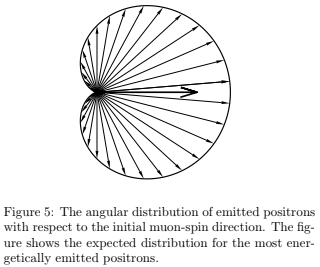

The code block below:
<li>Takes the inverse of the positron emission function
<li>Samples large set to get full distribution
<li>Displays histogram of angular distribution

In [6]:
# Inverse of positron decay diretion equation
def theta_predict(W, a0):
    value = (W-1) / a0
    if abs(value) > 1:
        print("np.arccos() can only take {-1, 1}")
        print(f"w: {W})\nValue: {value}")
        return None
    """
    Multiply by 2 because arccos returns {0, pi}
    Desired output should be {0, 2pi}
    """
    return np.arccos((W-1) / a0)*2

In [7]:
N = 100000
angles = np.zeros(N)

for i in range(N):
    """
    Range {0, 2}
    By symmetry of cyclic function
    """
    U = np.random.uniform(0, 2)
    angles[i] = theta_predict(U, 1)

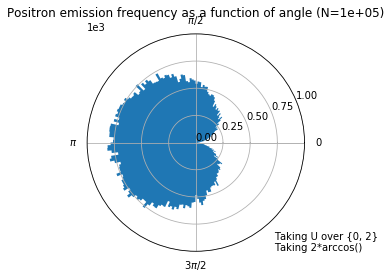

In [8]:
fig = plt.figure()
ax = plt.subplot(111, projection="polar")
ax.hist(angles, bins=200, histtype="stepfilled")
ax.set_xticks(np.linspace(0, 2*np.pi, 5))
ax.set_xticklabels(["0", "$\pi/2$", "$\pi$", "$3\pi/2$", "",])
ax.set_yticks(np.linspace(0, 1000, 5))
ax.set_title("Positron emission frequency as a function of angle (N={:.0e})".format(N))
ax.annotate(s="Taking U over {0, 2}\nTaking 2*arccos()", xy=(0.7, 0.1), xycoords="figure fraction")
plt.savefig("Images/Positron_emmision_whole.png")

## Histogram of decay times
Demonstrating the exponential decay of lifetimes for the muons and attempting to fit and the subtract the exponential to be left with continuous moun decay

In [9]:
# Used for curve_fitting the exponential term
def expon(x, A, k):
    return A*np.exp(x*k)

In [ ]:
hist_points = int(N/100)
plt.figure()
freq, bins, _ = plt.hist(times, density=False, range=(0, 20e-6))
"""
#plt.clf()
bins = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

time_array = np.linspace(0, 20e-6, hist_points)
popt, cpov = curve_fit(expon, bins, freq, p0=[100, -100])
fitted_freq = expon(time_array, *popt)

# Plotting
plt.plot(bins, freq, label="Particle lifetimes")
plt.plot(time_array, fitted_freq, label="Fitted exponential decay")
plt.plot(bins, (freq-fitted_freq), label="Muons minus exponential")

# Formatting
plt.xlabel("Time of decay (s)")
plt.ylabel("Frequency")
plt.title(f"Muon lifetimes: N={N}, num bins={hist_points}")
func.format_plot()
"""

KeyboardInterrupt: 

## Attempting to retrieve the Kubo-Toyabe function from the generated muons

In [24]:
def get_spin_relaxation(field, time, gyro):
    return (1/3) + ((2/3)*(np.cos(gyro * time * field)))

def gaussian_field(width, field):
    """
    Gaussian distribution for muon sensing field
    """
    term1 = (Muon().gyro_ratio) / (((2*np.pi)**0.5) * width)
    term2 = np.exp( (-(Muon().gyro_ratio)**2) * (field**2) / (2*(width**2)))
    return term1 * term2

def get_kubo_toyabe_factor(parameter, t):
    """
    There is no dependence on field strength here. Only on width of field distribution
    """
    return (1/3) + ( (2/3) * (1-((parameter**2) * (t**2))) * np.exp(-0.5*(parameter**2)*(t**2)) ) 

Plotting the relaxation in magnetic fields with no distribution (all fields assumed to lie exactly on axis)

In [18]:
fields = [0.0001, 0.00015, 0.0002, 0.00025, 0.0003]  # Field strength in Tesla
widths = [1e4, 5e4, 1e5]  # Width of random fields
times =  np.linspace(0, 200e-6, N)

angles = np.zeros([5, N])
angle_average = np.zeros(N)

# Creating data for different field strengths
for i, strength in enumerate(fields):
    for j, t in enumerate(times):
        angles[i][j] = get_spin_relaxation(strength, t, Muon.gyro_ratio)

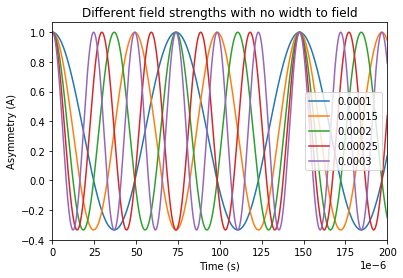

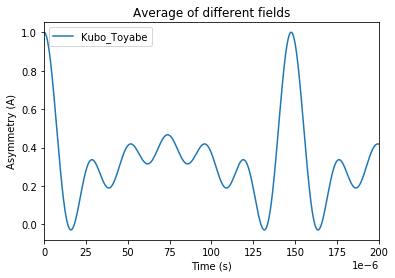

In [19]:
# Plotting field strength graphs
plt.figure()
for i in range(len(fields)):
    plt.plot(times, angles[i], label="{}".format(fields[i]))
    angle_average = np.add(angles[i], angle_average)
plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Different field strengths with no width to field")
plt.show()

# Plotting average graph
plt.figure()
angle_average = [i/5 for i in angle_average]
plt.plot(times, angle_average, label="Kubo_Toyabe")

plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Average of different fields")
plt.show()

#### KUBO-TOYABE FUNCTION
Adding random widths in range {1e4, 1e5} and averaging the results recovers the kubo-toyabe function

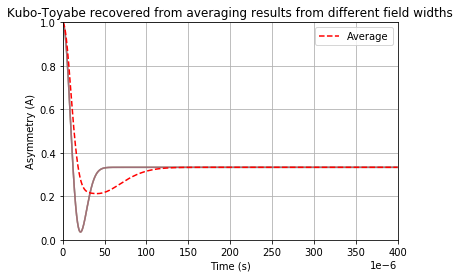

In [30]:
# Initiallising variables
fields = [0.001, 0.0015, 0.002, 0.0025, 0.003]
widths = np.random.uniform(1e4, 1e5, 5)
#widths=[1e4]
times =  np.linspace(0, 400e-6, N)

polar_av = np.zeros(N)
polarisation = np.zeros([len(widths), N])
field_width_polarisation = np.zeros([len(fields), N])

for i, w in enumerate(widths):
    for j, t in enumerate(times):
        polarisation[i][j] = get_kubo_toyabe_factor(w, t)
    polar_av = np.add(polar_av, polarisation[i]/len(widths))

# for i, field in enumerate(fields):
#     print(f"In field {i}...")
#     for j, time in enumerate(times):
#         field_width_polarisation[i][j] = gaussian_field(5e4, field)

# Plotting
plt.figure()
for i in range(len(widths)):
    #plt.plot(times, field_width_polarisation[increment,:], alpha=0.4)
    plt.plot(times, polarisation[increment,:], alpha=0.4)
    
plt.plot(times, polar_av, "--r", label="Average")

# Plot formatting
plt.legend(loc="best")
plt.xlim(0, 400e-6)
plt.ylim(0, 1)
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
#plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel("Time (s)")
plt.ylabel("Asymmetry (A)")
plt.title("Kubo-Toyabe recovered from averaging results from different field widths")
plt.show()